# Multi-Layer Perceptron

<br>
<br>

In [24]:
from IPython.display import Image
%matplotlib inline

# Modelando funções complexas com redes neurais artificiais

## Recapitulando a rede neural de camada única

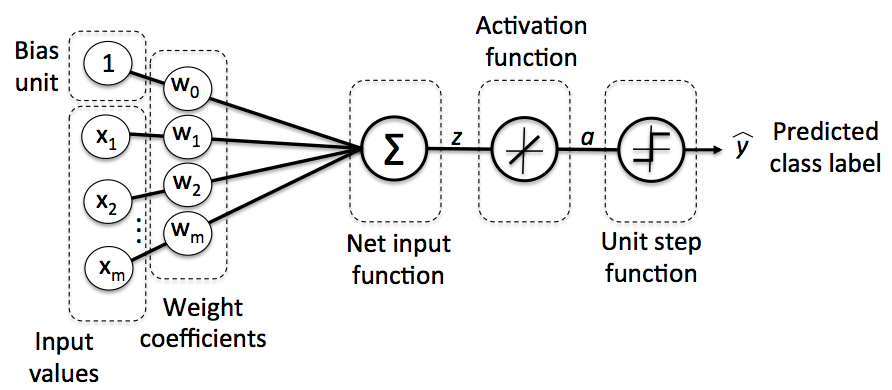

In [25]:
Image(filename='./images/12_01.png', width=600) 

<br>
<br>

## Apresentando a arquitetura de rede neural multicamada

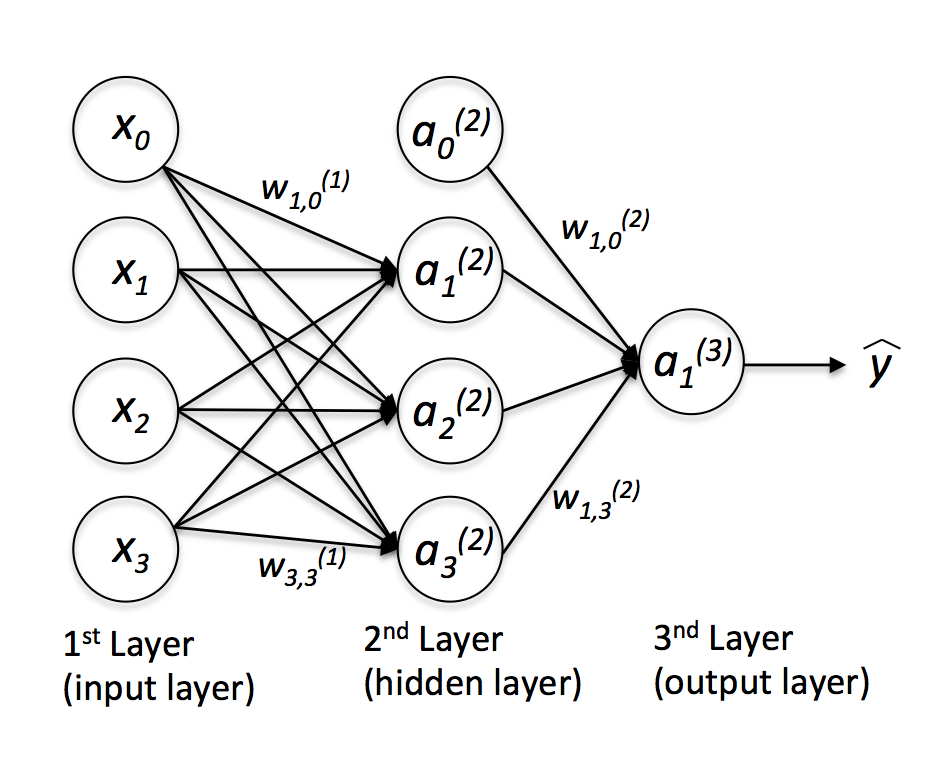

In [26]:
Image(filename='./images/12_02.png', width=400) 

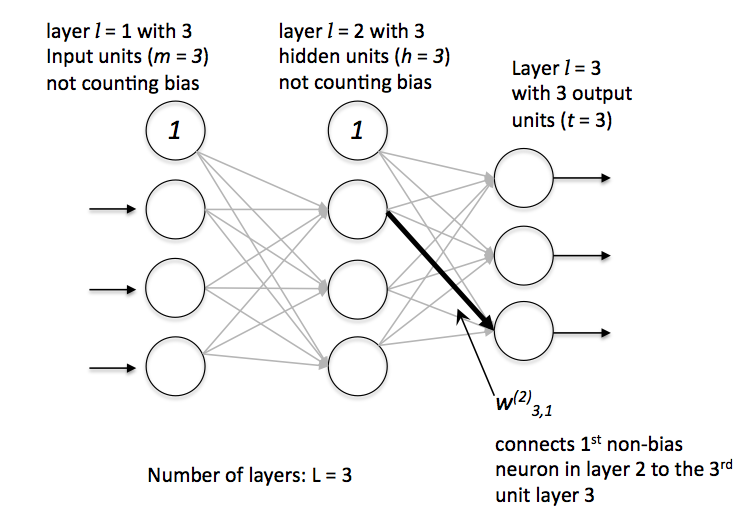

In [27]:
Image(filename='./images/12_03.png', width=500) 

<br>
<br>

## Ativando uma rede neural via forward propagation

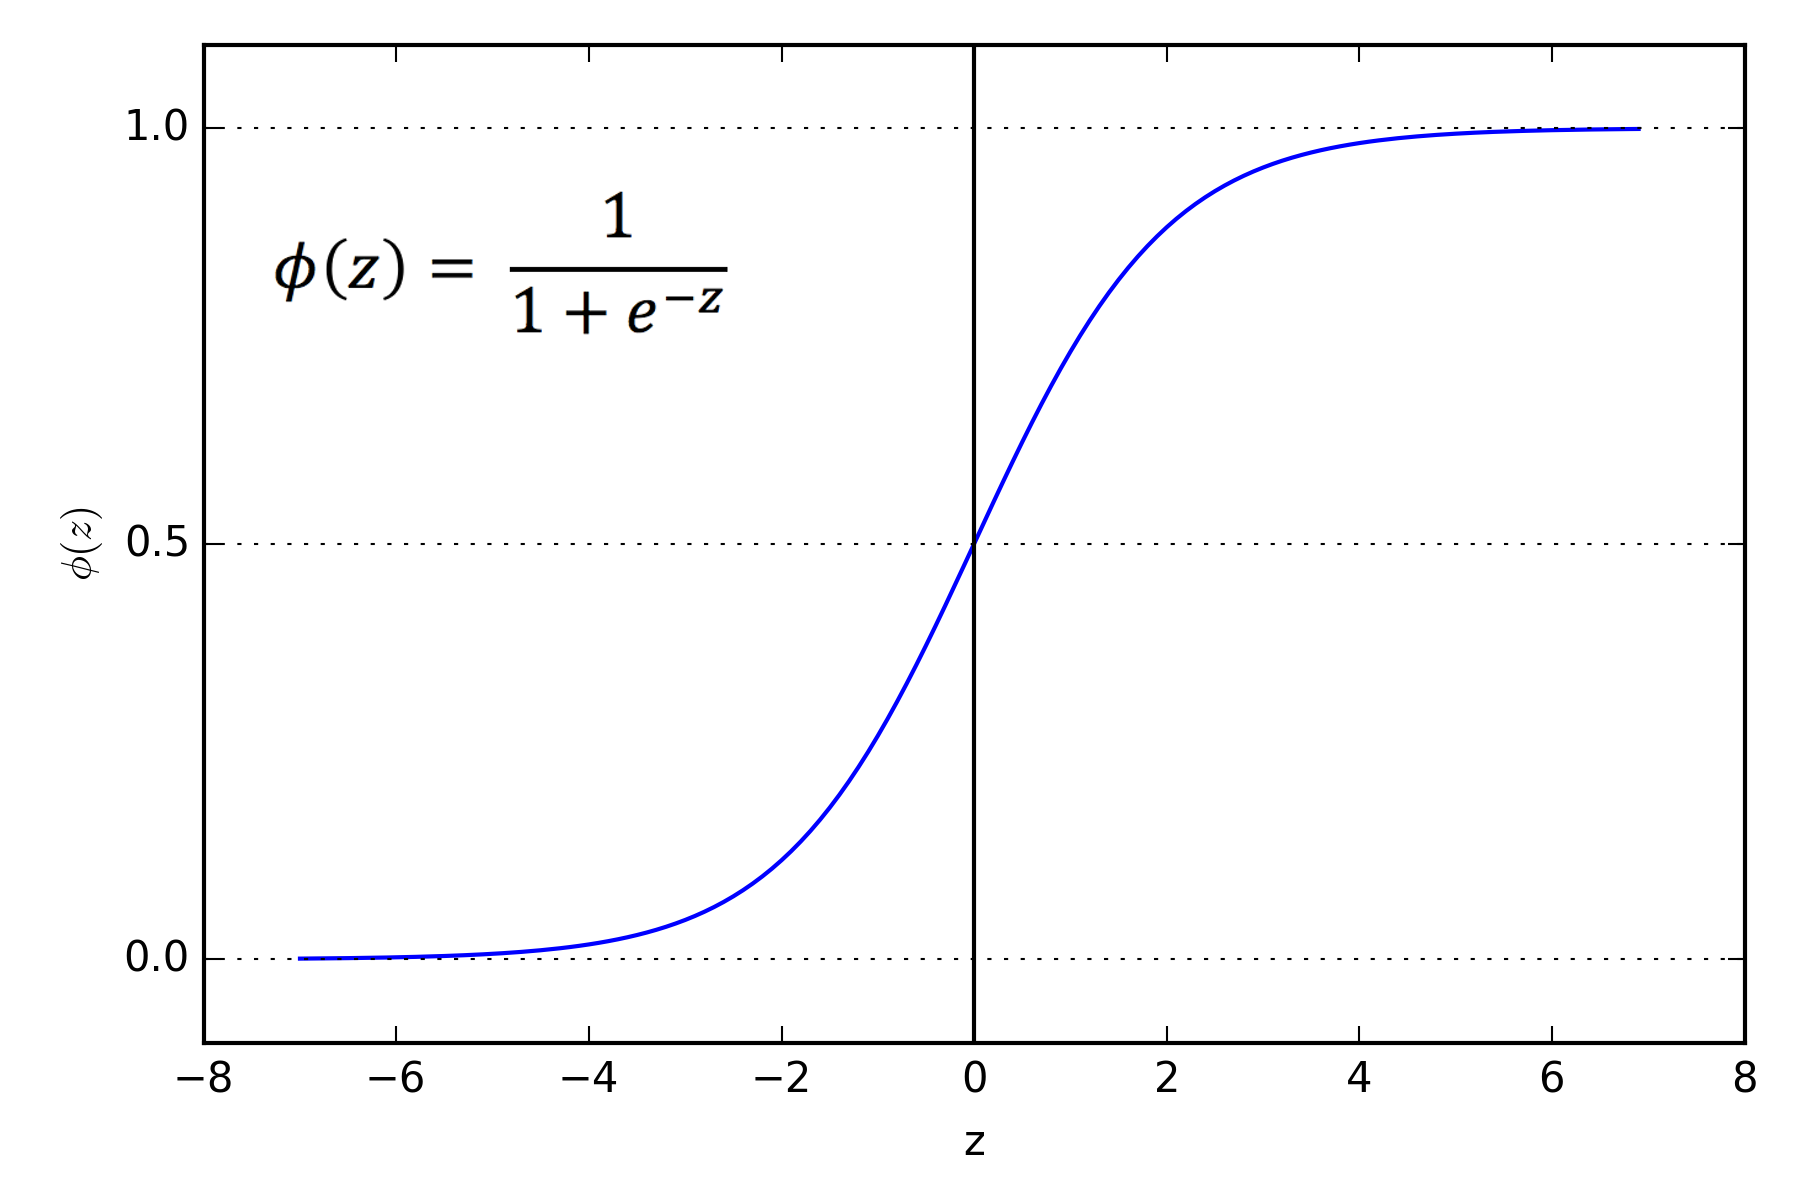

In [28]:
Image(filename='./images/12_04.png', width=500) 

<br>
<br>

# Classificação de dígitos manuscritos

O conjunto de dados MNIST está disponível publicamente em http://yann.lecun.com/exdb/mnist/ e consiste nas quatro partes a seguir:

- Imagens do conjunto de treinamento: train-images-idx3-ubyte.gz (9,9 MB, 47 MB descompactado, 60.000 amostras)
- Classes do conjunto de treinamento: train-labels-idx1-ubyte.gz (29 KB, 60 KB descompactado, 60.000 labels )
- Imagens do conjunto de testes: t10k-images-idx3-ubyte.gz (1,6 MB, 7,8 MB, 10 000 amostras)
- Classes do conjunto de teste: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB descompactado, 10.000 labels)

Trabalharemos apenas com um subconjunto do MNIST, portanto, precisamos apenas fazer o download das imagens do conjunto de treinamento e das classes do conjunto de treinamento. Depois de baixar os arquivos, eu recomendo descompactar os arquivos usando a ferramenta Unix / Linux gzip do terminal para eficiência, por exemplo, usando o comando

    gzip *ubyte.gz -d
 
no diretório local de download do MNIST, ou usando sua ferramenta de descompactação favorita, se estiver trabalhando com uma máquina em execução no Microsoft Windows. As imagens são armazenadas em byte, e usando a seguinte função, as leremos nos arrays NumPy que usaremos para treinar nossa MLP.


## Obtendo o conjunto de dados MNIST

In [29]:
import os
import struct
import numpy as np
import gzip
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte.gz' % kind)
        
    with gzip.open(labels_path, 'rb') as lbpath:
        lbpath.read(8)
        buffer = lbpath.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        imgpath.read(16)
        buffer = imgpath.read()
        images = np.frombuffer(buffer, 
                               dtype=np.uint8).reshape(
            len(labels), 784).astype(np.float64)
 
    return images, labels

In [30]:
X_train, y_train = load_mnist('mnist/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [31]:
X_test, y_test = load_mnist('mnist/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


Visualizando digitos de cada classe:

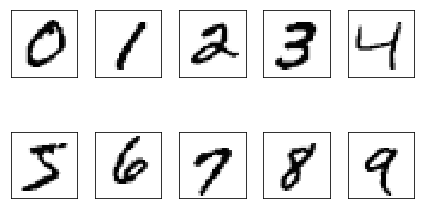

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

Visualizando 25 versões diferentes de "7":

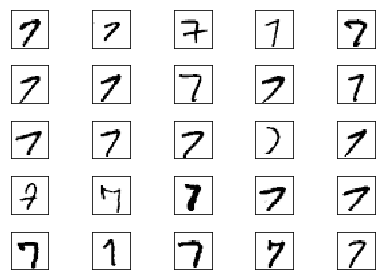

In [33]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_7.png', dpi=300)
plt.show()

Descomente as seguintes linhas para, opcionalmente, salvar os dados no formato CSV.
No entanto, observe que esses arquivos CSV ocuparão uma quantidade substancial de espaço de armazenamento:

- train_img.csv 1.1 GB (gigabytes)
- train_labels.csv 1.4 MB (megabytes)
- test_img.csv 187.0 MB
- test_labels 144 KB (kilobytes)


In [34]:
# np.savetxt('train_img.csv', X_train, fmt='%i', delimiter=',')
# np.savetxt('train_labels.csv', y_train, fmt='%i', delimiter=',')
# X_train = np.genfromtxt('train_img.csv', dtype=int, delimiter=',')
# y_train = np.genfromtxt('train_labels.csv', dtype=int, delimiter=',')

# np.savetxt('test_img.csv', X_test, fmt='%i', delimiter=',')
# np.savetxt('test_labels.csv', y_test, fmt='%i', delimiter=',')
# X_test = np.genfromtxt('test_img.csv', dtype=int, delimiter=',')
# y_test = np.genfromtxt('test_labels.csv', dtype=int, delimiter=',')


<br>
<br>

## Implementandos um multi-layer perceptron

In [35]:
import numpy as np
from scipy.special import expit
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
    n_hidden : int (default: 30)
        Number of hidden units.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

---
**Nota**

No método "fit" do exemplo MLP acima,

```python

for idx in mini:
...
    # compute gradient via backpropagation
    grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                      a3=a3, z2=z2,
                                      y_enc=y_enc[:, idx],
                                      w1=self.w1,
                                      w2=self.w2)

    delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
    self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
    self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
    delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
```

`delta_w1_prev` (O mesmo se aplica a `delta_w2_prev`) é uma exibição de memória de `delta_w1` via  

```python
delta_w1_prev = delta_w1
```
na ultima linha. Isso pode ser problemático, já que a atualização `delta_w1 = self.eta * grad1` mudaria `delta_w1_prev` também quando fazemos uma iteração no loop for. Note que este não é o caso aqui, porque nós atribuímos uma nova matriz para `delta_w1` a cada iteração -- a matriz de gradientes vezes a taxa de aprendizagem:

```python
delta_w1 = self.eta * grad1
```

A atribuição mostrada acima deixa o `delta_w1_prev` apontando para o velho `delta_w1`. Para ilustrar isso com um simples snippet, considere o seguinte exemplo:



In [36]:
import numpy as np

a = np.arange(5)
b = a
print('a & b', np.may_share_memory(a, b))


a = np.arange(5)
print('a & b', np.may_share_memory(a, b))

('a & b', True)
('a & b', False)


(Fim da nota.)

---

In [37]:
nn = NeuralNetMLP(n_output=10, 
                  n_features=X_train.shape[1], 
                  n_hidden=50, 
                  l2=0.1, 
                  l1=0.0, 
                  epochs=1000, 
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  minibatches=50, 
                  shuffle=True,
                  random_state=1)

In [16]:
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000

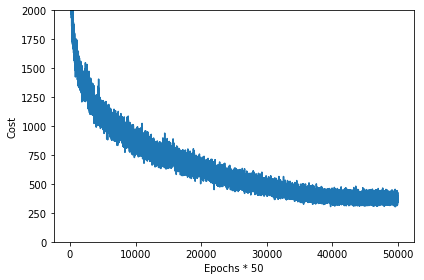

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
# plt.savefig('./figures/cost.png', dpi=300)
plt.show()

In [18]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

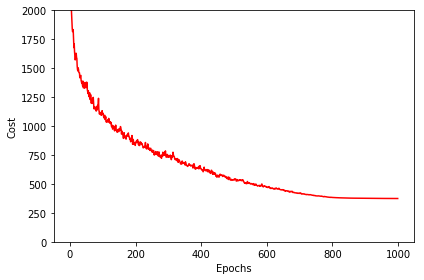

In [19]:
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

In [20]:
y_train_pred = nn.predict(X_train)

if sys.version_info < (3, 0):
    acc = ((np.sum(y_train == y_train_pred, axis=0)).astype('float') /
           X_train.shape[0])
else:
    acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.43%


In [21]:
y_test_pred = nn.predict(X_test)

if sys.version_info < (3, 0):
    acc = ((np.sum(y_test == y_test_pred, axis=0)).astype('float') /
           X_test.shape[0])
else:
    acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 95.61%


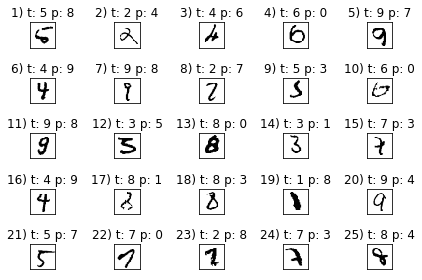

In [22]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

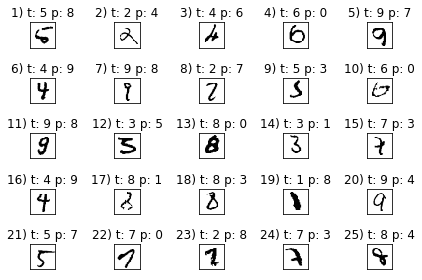

In [23]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab= y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_miscl.png', dpi=300)
plt.show()

<br>
<br>

# Developing your intuition for backpropagation

# Debugging neural networks with gradient checking

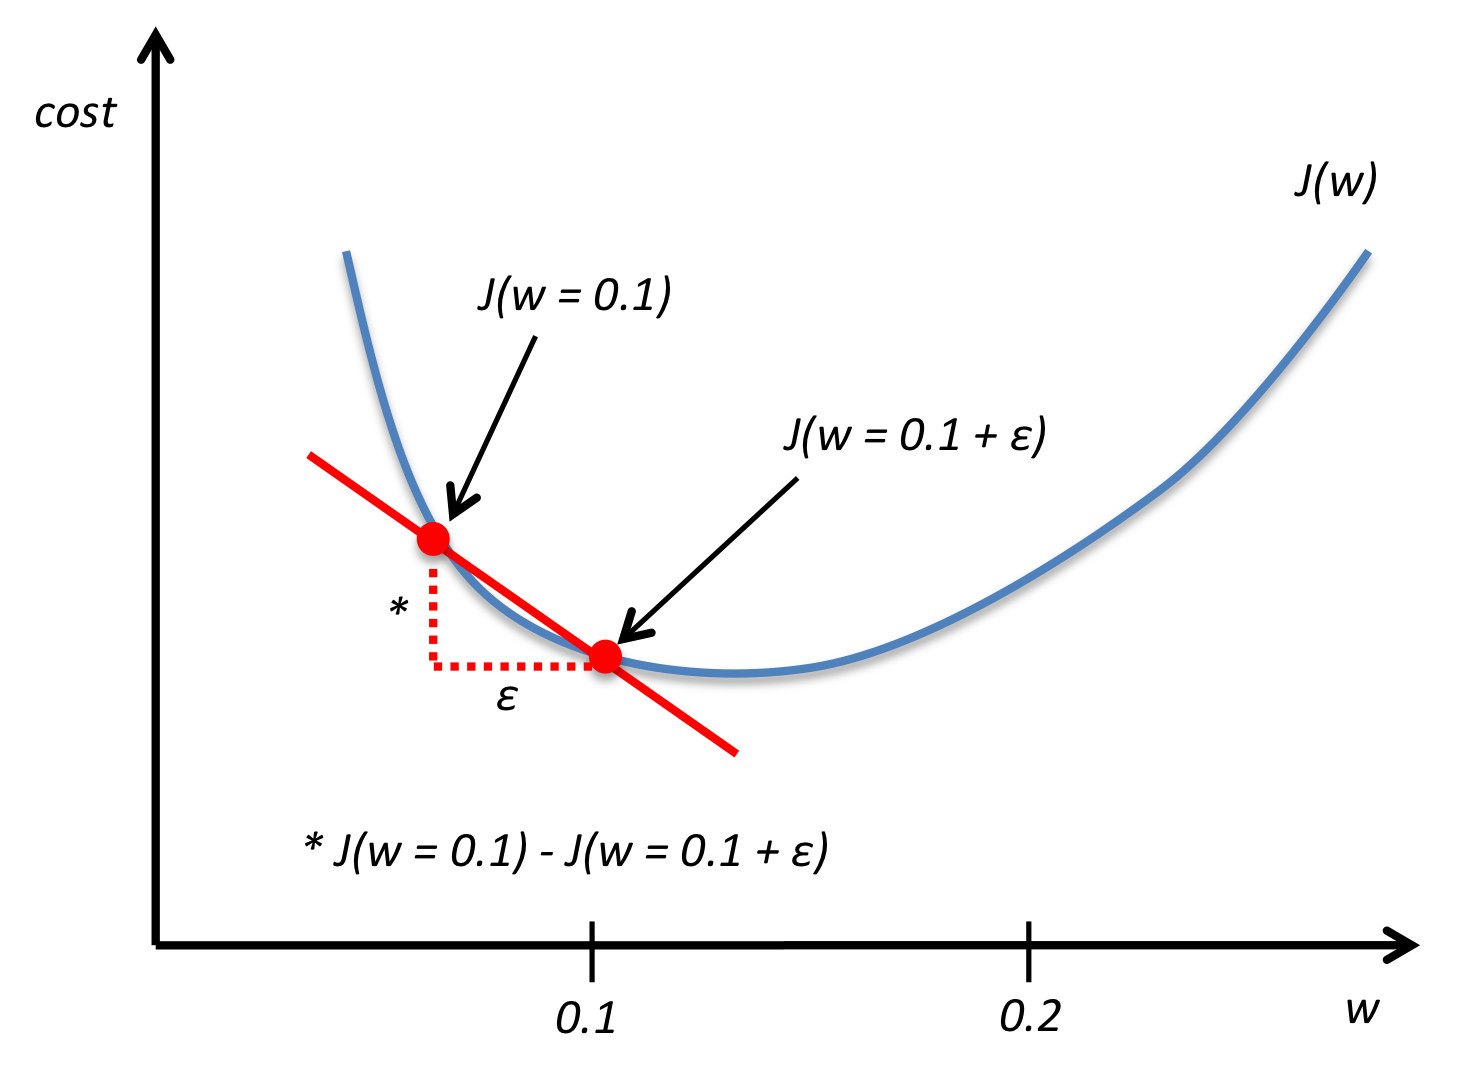

In [27]:
Image(filename='./images/12_13.png', width=500) 

In [6]:
from scipy import __version__ as scipy_ver
from numpy import __version__ as numpy_ver

print('The following code requires NumPy >= 1.9.1. Your NumPy version is %s.' % (numpy_ver))
print('The following code requires SciPy >= 0.14.0. Your SciPy version is %s. ' % (scipy_ver))

The following code requires NumPy >= 1.9.1. Your NumPy version is 1.11.0.
The following code requires SciPy >= 0.14.0. Your SciPy version is 0.17.0. 


In [5]:
import numpy as np
from scipy.special import expit
import sys


class MLPGradientCheck(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
    n_hidden : int (default: 30)
        Number of hidden units.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: False)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
        Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def _gradient_checking(self, X, y_enc, w1, w2, epsilon, grad1, grad2):
        """ Apply gradient checking (for debugging only)

        Returns
        ---------
        relative_error : float
          Relative error between the numerically
          approximated gradients and the backpropagated gradients.

        """
        num_grad1 = np.zeros(np.shape(w1))
        epsilon_ary1 = np.zeros(np.shape(w1))
        for i in range(w1.shape[0]):
            for j in range(w1.shape[1]):
                epsilon_ary1[i, j] = epsilon
                a1, z2, a2, z3, a3 = self._feedforward(X,
                                                       w1 - epsilon_ary1, w2)
                cost1 = self._get_cost(y_enc, a3, w1-epsilon_ary1, w2)
                a1, z2, a2, z3, a3 = self._feedforward(X,
                                                       w1 + epsilon_ary1, w2)
                cost2 = self._get_cost(y_enc, a3, w1 + epsilon_ary1, w2)
                num_grad1[i, j] = (cost2 - cost1) / (2.0 * epsilon)
                epsilon_ary1[i, j] = 0

        num_grad2 = np.zeros(np.shape(w2))
        epsilon_ary2 = np.zeros(np.shape(w2))
        for i in range(w2.shape[0]):
            for j in range(w2.shape[1]):
                epsilon_ary2[i, j] = epsilon
                a1, z2, a2, z3, a3 = self._feedforward(X, w1,
                                                       w2 - epsilon_ary2)
                cost1 = self._get_cost(y_enc, a3, w1, w2 - epsilon_ary2)
                a1, z2, a2, z3, a3 = self._feedforward(X, w1,
                                                       w2 + epsilon_ary2)
                cost2 = self._get_cost(y_enc, a3, w1, w2 + epsilon_ary2)
                num_grad2[i, j] = (cost2 - cost1) / (2.0 * epsilon)
                epsilon_ary2[i, j] = 0

        num_grad = np.hstack((num_grad1.flatten(), num_grad2.flatten()))
        grad = np.hstack((grad1.flatten(), grad2.flatten()))
        norm1 = np.linalg.norm(num_grad - grad)
        norm2 = np.linalg.norm(num_grad)
        norm3 = np.linalg.norm(grad)
        relative_error = norm1 / (norm2 + norm3)
        return relative_error

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                # start gradient checking
                grad_diff = self._gradient_checking(X=X_data[idx],
                                                    y_enc=y_enc[:, idx],
                                                    w1=self.w1,
                                                    w2=self.w2,
                                                    epsilon=1e-5,
                                                    grad1=grad1,
                                                    grad2=grad2)


                if grad_diff <= 1e-7:
                    print('Ok: %s' % grad_diff)
                elif grad_diff <= 1e-4:
                    print('Warning: %s' % grad_diff)
                else:
                    print('PROBLEM: %s' % grad_diff)

                # update weights; [alpha * delta_w_prev] for momentum learning
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [29]:
nn_check = MLPGradientCheck(n_output=10, 
                            n_features=X_train.shape[1], 
                            n_hidden=10, 
                            l2=0.0, 
                            l1=0.0, 
                            epochs=10, 
                            eta=0.001,
                            alpha=0.0,
                            decrease_const=0.0,
                            minibatches=1, 
                            shuffle=False,
                            random_state=1)

In [30]:
nn_check.fit(X_train[:5], y_train[:5], print_progress=False)

Ok: 2.55068505986e-10
Ok: 2.93547837023e-10
Ok: 2.37449571314e-10
Ok: 3.08194323691e-10
Ok: 3.38249440642e-10
Ok: 3.57890221135e-10
Ok: 2.19231256383e-10
Ok: 2.36583740198e-10
Ok: 3.43584860701e-10
Ok: 2.13345208113e-10


<br>
<br>